In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
from scipy.interpolate import interp1d
from scipy.special import gamma
from ADVI import ADVI


In [2]:
data = pd.read_csv('taxi_porto/train.csv/train.csv')

In [3]:
data = data[data['MISSING_DATA']==False]


In [4]:
data.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


In [5]:
print(len(data))

1710660


In [6]:
coordinates = data['POLYLINE'].apply(literal_eval)


KeyboardInterrupt: 

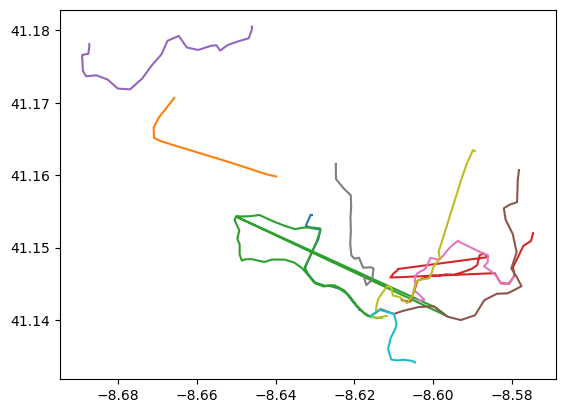

In [ ]:
for i in range(10):     
    plt.plot(np.array(coordinates[i])[:,0],np.array(coordinates[i])[:,1])

In [ ]:
coordinates_interp = []
for traj in coordinates:
    if len(traj)>0:
        x=np.array(traj)[:,0]
        y=np.array(traj)[:,1]
        t = np.linspace(0,50,len(x))
        t_interp = np.linspace(0,50,50)
        x_interp = np.interp(t_interp,t,x)
        y_interp = np.interp(t_interp,t,y)
        coordinates_interp.append([x_interp,y_interp])

In [ ]:
coordinates_interp = np.array(coordinates_interp)
print(coordinates_interp.shape)

(1704759, 2, 50)


In [ ]:
coordinates_1d = coordinates_interp.reshape(-1,100)
print(coordinates_1d.shape)
np.save('coordinates.npy',coordinates_1d)

NameError: name 'coordinates_interp' is not defined

In [ ]:
coordinates_1d = np.load('coordinates.npy')

In [ ]:
D=12

def inv_T(x):
    return np.concatenate((x[:-D-1], np.log(x[-D-1:])))


class taxi_distribution():
    def __init__(self, D, X):
        (self.N,self.M)=X.shape
        self.X = X
        self.D = D
        self.theta_size = self.D*self.M+self.N*self.M+self.M+1

    def log_gaussian(self,x,mu,sigma):
        return - 0.5*np.log((2*np.pi)**len(x)*np.linalg.det(sigma))-(x-mu)@np.linalg.inv(sigma)@(x-mu).T/2

    def log_loggaussian(self,x,mu,sigma):
        return - 0.5*np.log((2*np.pi)**len(x)*np.linalg.det(sigma)*x**2)-(np.log(x)-mu)@np.linalg.inv(sigma)@(np.log(x)-mu).T/2

    def log_invgamma(self,x,a,b):
        return (b**a / gamma(a)) * x**(-a-1) * np.exp(-b / x)

    def log_distr(self,X,theta):
        print(theta.shape)
        (W,Z,alpha,sigma) = theta[0:self.D*self.M], theta[self.D*self.M:self.D*self.M+self.N*self.M],theta[self.D*self.M+self.N*self.M:-1],theta[-1:] 
        W = W.reshape((self.D,self.M))
        Z = Z.reshape((self.N,self.M))
        conditionnal = np.sum([self.log_gaussian(x,W@(Z[n])) for n,x in enumerate(X)])
        distr_sigma = self.log_loggaussian(sigma,1,1)
        distr_z = np.sum([self.log_gaussian(z,0,1) for z in Z])
        distr_alpha = np.sum([self.log_invgamma(alpha_m,1,1) for alpha_m in alpha])
        distr_w = np.sum([self.gaussian(w,0,sigma*np.diag(alpha)) for w in W])

        return conditionnal + distr_sigma + distr_z + distr_alpha + distr_W
   
     


In [ ]:
taxi_distr =taxi_distribution(D,coordinates_1d)

model = ADVI(inv_T,taxi_distr, coordinates_1d,dependant=False)

In [ ]:
model.fit()